# Unsupervised learning algorithms

In this document I am going to build an easy practice dataset, and practice clustering using different supervised learning algorithms.

Things that I want to implement here:
- build easy dataset myself with 2 different clusters
- how to determine test performance exactly in clustering (where there is no "correct" answer)?
    - use the k-fold cross validation tactic to verify the statistical robustness of my algorithm's performance
    - test perfromance

- implement k-means clustering algorithm
- implement DBSCAN
- implement another algorithms?

Well, let's get started. Wish me luck and endurance! :)

# Build data set for clustering

In [146]:
# import packages
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import math
import matplotlib.pyplot as plt


In [147]:
# Build mock dataset

feature1 = [1, 2, 3, 2, 3, 3, 3, 3,  4, 5, 5, 18, 8,9, 16,17, 11, 9, 9, 9,10, 10, 11, 12, 13, 14, 14, 15, 14,12, 13, 14, 11, 12, 14]
feature2 = [3, 2, 5, 3, 1, 4, 1, 3,  3, 4, 2, 19, 17, 14, 10, 15, 11, 12, 14, 19,16, 17, 9, 10, 10, 19, 18, 17, 19, 13, 14, 15, 15, 16, 11]

mock_data = []

for i in range(len(feature1)):
    mock_data.append((feature1[i], feature2[i],))


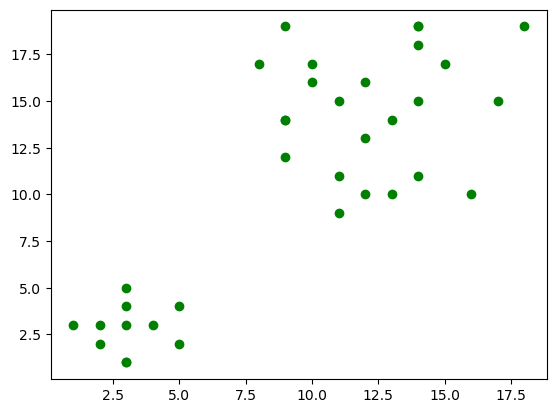

In [148]:
# Visualize mock data to show that it fits well with two clusters

plt.plot(feature1, feature2, "o", color="green")
plt.show()

# K-Means Algorithm

 Partitioning method
 
    - Input:
        - D = {p1,..., pn} points to be clustered (with their m-dimensions)
        - k  = number of clusters (have to be specified?!)
    - Output:
        - C = {c1,...,ck} Cluster centroids
        - M: D -> {1,...,k} cluster membership
    - Method:
        - arbitrarily choose k objects from D as the initial cluster centres
        - repeat:
            - reassign each object to the cluster to which the object is most similar, 
                (based on MEAN VALUE of the objects in the  cluster)
            - update the cluster means (= calculate the mean value of the objects for each cluster)
        - until no change

In [276]:
class KMeansClustering:

    # attributes
    k = None
    setWithDataTuples = None
    kDataPoinsInSet = None
    dictWithMappingAllPointsToK = None
    newKPointsinSet = None
    clusterCentroids = None
    clusterMemberships = None
    colourMap = None
    listOfColours = ["black", "green", "orange", "darkred", "darkblue", "lightblue", "purple", "pink", "cyan", "olive", "gray", "lightpink"]


    # constructor
    def __init__(self, setWithDataTuples, k):
        self.setWithDataTuples = setWithDataTuples
        self.k = k
        
    def __str__(self):
        return "K-Means Clustering Object" 
    


    # define all helper methods

    def __defineRandomKStart(self):
        # initiate list to store k random points
        kDataPointsInSet = set()
        # randomly draw k numbers in the rande of how long listWithDataTuples is
        rng = np.random.default_rng()
        randomPositionsOfKPoints = rng.integers(low=0, high=len(self.setWithDataTuples), size=self.k)
        # chose k points as random start points
        for i in randomPositionsOfKPoints:
            kDataPointsInSet.add(self.setWithDataTuples[i])
        
        # map colours to initial k points
        colourMap = {}
        number = 0
        for i in kDataPointsInSet:
            number += 1
            colourMap[i] = self.listOfColours[number]
        self.colourMap = colourMap
        
        return(kDataPointsInSet)
    


    def __mapAllPointsToNearestK(self, setOfKs):
        # calculate distance from each point to all k points
        dictWithMappingAllPointsToK = {}
        for k in setOfKs:
            dictWithMappingAllPointsToK[k] = []

        for i in self.setWithDataTuples:
            allDistancesFromOnePointToAllK = {}
            for l in setOfKs:
                allDistancesFromOnePointToAllK[l] = (self.__getEuclideanDistance(i[0], i[1], l[0], l[1]))
            # assign each point to the k-point which is closest
            # für minimales k:
            minK = min(allDistancesFromOnePointToAllK, key=allDistancesFromOnePointToAllK.get)
            dictWithMappingAllPointsToK[minK].append(i)

        return(dictWithMappingAllPointsToK)



    def __calcKNewMeans(self, dictWithMappingAllPointsToK):
        newKPointsinSet = set()
        for listWithPoints in dictWithMappingAllPointsToK.values():
            newMeanXCoordinate = []
            newMeanYCoordinate = []
            for i in range(len(listWithPoints)):
                newMeanXCoordinate.append(listWithPoints[i][0])
                newMeanX = round(sum(newMeanXCoordinate)/len(newMeanXCoordinate), 6)
                newMeanYCoordinate.append(listWithPoints[i][1])
                newMeanY = round(sum(newMeanYCoordinate)/len(newMeanYCoordinate), 6)
            newKPointsinSet.add((newMeanX, newMeanY,))

        # map colours to new centroids (that are closest to old ones)
        self.__reassignColorsToCentroids(newKPointsinSet)
            
        
        return(newKPointsinSet)
    

    def __reassignColorsToCentroids(self, newCentroids):
        # Dictionary to store the updated color mapping
        newColorMapping = {}
        
        # Find closest new centroid for each old centroid and assign the same color
        usedNewCentroids = set()
        for oldCentroid in self.colourMap:
            closestNewCentroid = min(newCentroids, key=lambda newCentroid: self.__getEuclideanDistance(oldCentroid[0], oldCentroid[1], newCentroid[0], newCentroid[1]))
            newColorMapping[closestNewCentroid] = self.colourMap[oldCentroid]
            usedNewCentroids.add(closestNewCentroid)
        
        # Find remaining colors from old centroids (i.e., those not reused)
        remainingColors = set(self.colourMap.values()) - set(newColorMapping.values())
        
        # Find new centroids that haven't been assigned a color yet
        unusedNewCentroids = set(newCentroids) - usedNewCentroids
        
        # Assign remaining colors from old centroids to new centroids
        for newCentroid in unusedNewCentroids:
            if remainingColors:
                newColorMapping[newCentroid] = remainingColors.pop()
            else:
                # Fallback if no remaining colors (this shouldn't happen with enough colors)
                newColorMapping[newCentroid] = "gray"
        
        # Update the color mapping to the new centroids
        self.colourMap = newColorMapping
    





    # main functions

    def cluster(self):

        # arbitrarily choose k objects from D as the initial cluster centres
        kDataPointsInSet = self.__defineRandomKStart()

        # assign each object to the cluster to which the object is most similar and update cluster means until no change
        mappingOld = 1
        mappingEnd = 0
        while mappingOld != mappingEnd:
            mappingOld = self.__mapAllPointsToNearestK(kDataPointsInSet)
            kDataPointsInSet = self.__calcKNewMeans(mappingOld)
            mappingEnd = self.__mapAllPointsToNearestK(kDataPointsInSet)

            self.clusterCentroids = kDataPointsInSet
            self.clusterMemberships = mappingEnd
            self.visualize()

        return(kDataPointsInSet, mappingEnd)
    

    def visualize(self):

        listWithListsX = []
        listWithListsY = []

        for centroid in self.clusterCentroids:
            oneListWithX = []
            oneListWithY = []
            for x in self.clusterMemberships[centroid]:
                oneListWithX.append(x[0])
            for y in self.clusterMemberships[centroid]:
                oneListWithY.append(y[1])
            listWithListsX.append(oneListWithX)
            listWithListsY.append(oneListWithY)
        

        for i in range(len(listWithListsX)):   
            centroid = list(self.clusterCentroids)[i] 
            plt.plot(listWithListsX[i], listWithListsY[i], "o", color=self.colourMap[centroid])
        plt.show()



    # helper function: calculate euclidean distance with 2 coordinates of the train and two coordinates of the test data 
    ### todo: can I generalize the function to take in any input coordinate length?!
    @staticmethod
    def __getEuclideanDistance(trainData1Coordinate, trainData2Coordinate, testData1Coordinate, testData2Coordinate):
        distance = math.sqrt((trainData1Coordinate-testData1Coordinate)**2+(trainData2Coordinate-testData2Coordinate)**2)
        return(distance)
    

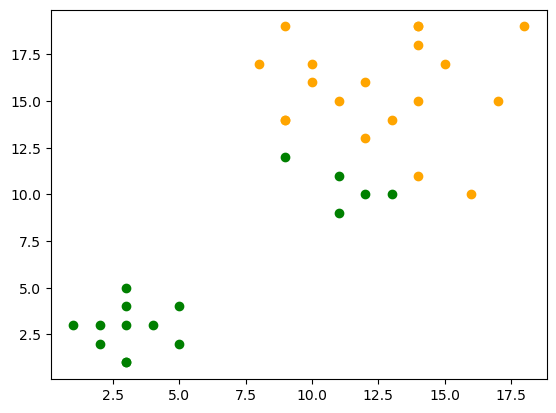

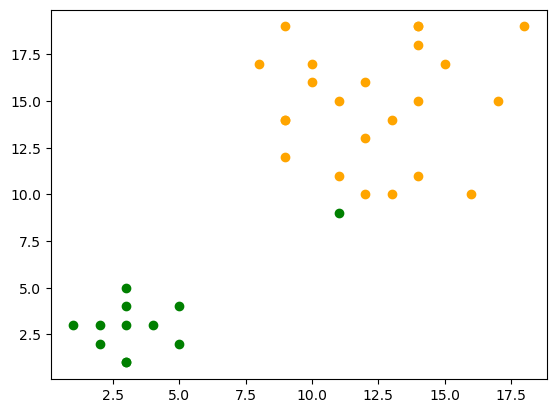

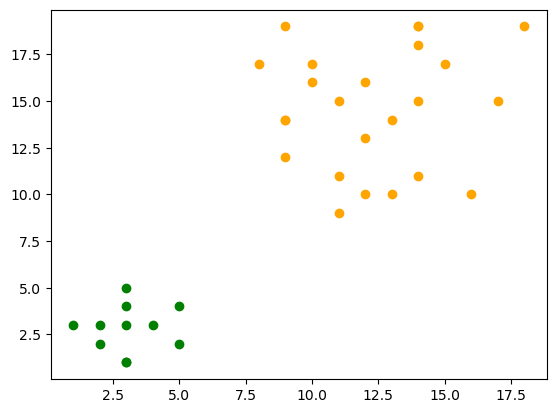

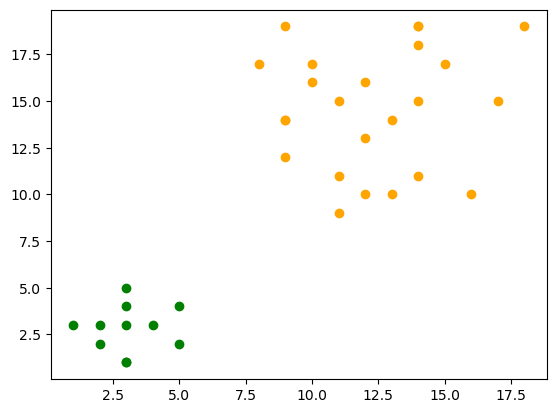

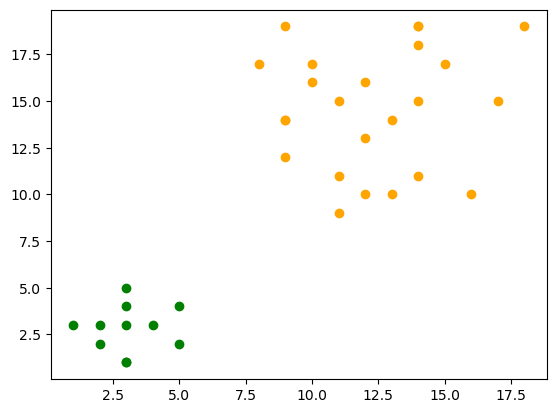

({(3.090909, 2.818182), (12.291667, 14.583333)},
 {(12.291667, 14.583333): [(18, 19),
   (8, 17),
   (9, 14),
   (16, 10),
   (17, 15),
   (11, 11),
   (9, 12),
   (9, 14),
   (9, 19),
   (10, 16),
   (10, 17),
   (11, 9),
   (12, 10),
   (13, 10),
   (14, 19),
   (14, 18),
   (15, 17),
   (14, 19),
   (12, 13),
   (13, 14),
   (14, 15),
   (11, 15),
   (12, 16),
   (14, 11)],
  (3.090909, 2.818182): [(1, 3),
   (2, 2),
   (3, 5),
   (2, 3),
   (3, 1),
   (3, 4),
   (3, 1),
   (3, 3),
   (4, 3),
   (5, 4),
   (5, 2)]})

In [281]:
newModel = KMeansClustering(mock_data, 2)
newModel.cluster()


# DBSCAN Algorithm

- Density based theory: 
    - Idea: Clusters are dense areas, seperated by areas of lower density
    - e=max distance (defined)
    - MinPts defined
    - D = {p1,..., pn} points to be clustered (with their m-dimensions)

    - Core objects: within defined e there are at least MinPts object reachable from the object
    - Border objects: no core object but density reachable by a core object, border points can only join a cluster, not extend it further!

    - directly density-reachable objects
    - density-reachable objects
    - density-connected

- algorithm pseudo-code:

    Input: e, MinPts, set with datapoints as tuples
    
    Output: Cluster of data points with noise

    1. Select an unprocessed data point P and retrieve all points density-reachable (neighbours) from P with respect to given e and MinPts

    2. If P is a core point, a cluster is formed
       else, P is classified as noise
    
    3. retrieve all points density-reachable from neighbour points and assign them to current cluster

    4. If P or neighbour is a border point, no points are density-reachable from P. Go to step 1.

    5. Continue algorithm until all data points have been processed.



In [328]:
# Build mock dataset

feature1 = [1, 2, 3, 2, 3, 3, 3, 3,  4, 5, 5, 18, 8,9, 16,17, 11, 9, 9, 9,10, 10, 11, 12, 13, 14, 14, 15, 14,12, 13, 14, 11, 12, 14]
feature2 = [3, 2, 5, 3, 1, 4, 1, 3,  3, 4, 2, 19, 17, 14, 10, 15, 11, 12, 14, 19,16, 17, 9, 10, 10, 19, 18, 17, 19, 13, 14, 15, 15, 16, 11]

mockData = set()

for i in range(len(feature1)):
    mockData.add((feature1[i], feature2[i],))


In [323]:
import random

In [332]:
# helper function: calculate euclidean distance with 2 coordinates of the train and two coordinates of the test data 
### todo: can I generalize the function to take in any input coordinate length?!
def getEuclideanDistance(trainData1Coordinate, trainData2Coordinate, testData1Coordinate, testData2Coordinate):
    distance = math.sqrt((trainData1Coordinate-testData1Coordinate)**2+(trainData2Coordinate-testData2Coordinate)**2)
    return(distance)



def getAllCorePoints(setWithDataTuples, e, MinPts):
    corePoints = set()
    for dataPoint in setWithDataTuples:
        neighbours = set()
        for potentialNeighbour in setWithDataTuples:
            if getEuclideanDistance(potentialNeighbour[0], potentialNeighbour[1], dataPoint[0], dataPoint[1]) <= e and dataPoint != potentialNeighbour:
                neighbours.add(potentialNeighbour)
        if len(neighbours) >= MinPts:
            corePoints.add(dataPoint)
    return(corePoints)

corePoints = getAllCorePoints(mockData, e = 3, MinPts = 4)

def DBSCAN(setWithDataTuples, e, MinPts):

    corePoints = getAllCorePoints(mockData, e , MinPts)

    listOfClusters = []
    listOfNoise = []
    unprocessedDataPoints = setWithDataTuples

    while len(unprocessedDataPoints) != 0:
        pointInProgress = random.choice(list(unprocessedDataPoints))
        cluster = []
        neighbourStack = []
        if pointInProgress in corePoints:
            cluster.append(pointInProgress)
            neighbours = [item for item in unprocessedDataPoints if getEuclideanDistance(pointInProgress[0], pointInProgress[1], item[0], item[1]) <= e]
            for neighbour in neighbours:
                if neighbour in corePoints:
                    cluster.append(neighbour)
                    neighbourStack.append(neighbour)
            while len(neighbourStack) != 0:
                # recursive thingi
            for dataPoint in unprocessedDataPoints:
                if dataPoint in cluster:
                    unprocessedDataPoints.remove(dataPoint)
            for  dataPoint in unprocessedDataPoints:
                for item in cluster:
                    if getEuclideanDistance(pointInProgress[0], pointInProgress[1], item[0], item[1]) <= e and dataPoint not in cluster:
                        cluster.append(dataPoint)
            for dataPoint in unprocessedDataPoints:
                if dataPoint in cluster:
                    unprocessedDataPoints.remove(dataPoint)
            listOfClusters.append(cluster)

            



                

    






    return(listOfClusters, listOfNoise)



# test 
DBSCAN(mockData, e = 4, MinPts = 3)





{(3, 4): {(1, 3),
  (2, 2),
  (2, 3),
  (3, 1),
  (3, 3),
  (3, 5),
  (4, 3),
  (5, 2),
  (5, 4)},
 (4, 3): {(1, 3),
  (2, 2),
  (2, 3),
  (3, 1),
  (3, 3),
  (3, 4),
  (3, 5),
  (5, 2),
  (5, 4)},
 (3, 1): {(1, 3), (2, 2), (2, 3), (3, 3), (3, 4), (4, 3), (5, 2)},
 (12, 10): {(11, 9), (11, 11), (12, 13), (13, 10), (14, 11)},
 (5, 4): {(3, 3), (3, 4), (3, 5), (4, 3), (5, 2)},
 (12, 16): {(10, 16),
  (10, 17),
  (11, 15),
  (12, 13),
  (13, 14),
  (14, 15),
  (14, 18)},
 (12, 13): {(11, 11),
  (11, 15),
  (12, 10),
  (12, 16),
  (13, 14),
  (14, 11),
  (14, 15)},
 (2, 2): {(1, 3), (2, 3), (3, 1), (3, 3), (3, 4), (4, 3), (5, 2)},
 (1, 3): {(2, 2), (2, 3), (3, 1), (3, 3), (3, 4), (3, 5), (4, 3)},
 (11, 11): {(9, 12), (11, 9), (12, 10), (12, 13), (13, 10), (14, 11)},
 (13, 14): {(11, 15), (12, 13), (12, 16), (14, 15)},
 (15, 17): {(14, 15), (14, 18), (14, 19), (17, 15)},
 (3, 3): {(1, 3),
  (2, 2),
  (2, 3),
  (3, 1),
  (3, 4),
  (3, 5),
  (4, 3),
  (5, 2),
  (5, 4)},
 (14, 18): {(12, 16), 

In [319]:
# helper function: calculate euclidean distance with 2 coordinates of the train and two coordinates of the test data 
### todo: can I generalize the function to take in any input coordinate length?!
def getEuclideanDistance(trainData1Coordinate, trainData2Coordinate, testData1Coordinate, testData2Coordinate):
    distance = math.sqrt((trainData1Coordinate-testData1Coordinate)**2+(trainData2Coordinate-testData2Coordinate)**2)
    return(distance)

def getNumberNeighbours(listWithDataPoints, dataPoint, e):
    neighbours = []
    for item in listWithDataPoints:
        if getEuclideanDistance(dataPoint[0], dataPoint[1], item[0], item[1]) >= e:
            neighbours.append(item)

    numberNeighbours = len(neighbours)
    return(numberNeighbours, neighbours)


def isPointCorePoint(numberNeighbours, e):
    if numberNeighbours >= e:
        True
    else:
        False


def DBSCAN(setWithDataTuples, e, MinPts):
    listWithNoise = []
    unprocessedDataTuples = []
    numberCluster = 0
    listOfPointsInCluster = []

    for dataTuple in setWithDataTuples:
        unprocessedDataTuples.append(dataTuple)    
    
    while len(unprocessedDataTuples) != 0:
        print(len(unprocessedDataTuples))

        pointInProgress = unprocessedDataTuples[0]
        print(pointInProgress)
        unprocessedDataTuples.remove(pointInProgress)

        numberNeighbours , neighbours = getNumberNeighbours(unprocessedDataTuples, pointInProgress, e)

        if numberNeighbours >=MinPts:
            numberCluster+=1
            allPointsInCluster = set(pointInProgress)
            for neighbour in neighbours:
                allPointsInCluster.add(neighbour)
                for item in unprocessedDataTuples:
                    if getEuclideanDistance(neighbour[0], neighbour[1], item[0], item[1]) >= e:
                        allPointsInCluster.add(item)
                unprocessedDataTuples.remove(neighbour)
            listOfPointsInCluster.append(allPointsInCluster)
        
        elif: 
            for neighbour in neighbours:
                numberNeighboursOfNeighbours , neighboursOfNeighbours = getNumberNeighbours(unprocessedDataTuples, neighbour, e)


        else:
            listWithNoise.append(pointInProgress)

    return(listOfPointsInCluster, numberCluster)

           



        




        



IndentationError: expected an indented block after 'for' statement on line 38 (1464433277.py, line 41)

In [321]:
type(mock_data)

list

In [318]:
DBSCAN(mock_data, 10, 1)

35
(1, 3)
10
(2, 2)
9
(3, 5)
8
(2, 3)
7
(3, 1)
6
(3, 4)
5
(3, 1)
4
(3, 3)
3
(4, 3)
2
(5, 4)
1
(5, 2)


([{(10, 16),
   (10, 17),
   (11, 11),
   (11, 15),
   (11, 9),
   (12, 10),
   (12, 13),
   (12, 16),
   (13, 10),
   (13, 14),
   (14, 11),
   (14, 15),
   (14, 18),
   (14, 19),
   (15, 17),
   (16, 10),
   (17, 15),
   (18, 19),
   (2, 2),
   (2, 3),
   (3, 1),
   (3, 3),
   (3, 4),
   (3, 5),
   (4, 3),
   (5, 2),
   (5, 4),
   (8, 17),
   (9, 12),
   (9, 14),
   (9, 19),
   1,
   3}],
 1)

# Old programming stuff

In [206]:
# helper function: calculate euclidean distance with 2 coordinates of the train and two coordinates of the test data 
### todo: can I generalize the function to take in any input coordinate length?!
def getEuclideanDistance(trainData1Coordinate, trainData2Coordinate, testData1Coordinate, testData2Coordinate):
    distance = math.sqrt((trainData1Coordinate-testData1Coordinate)**2+(trainData2Coordinate-testData2Coordinate)**2)
    return(distance)

In [207]:
def defineRandomKStart(setWithDataTuples, k):
    # initiate list to store k random points
    kDataPoinsInSet = set()
    # randomly draw k numbers in the rande of how long listWithDataTuples is
    rng = np.random.default_rng()
    randomPositionsOfKPoints = rng.integers(low=0, high=len(setWithDataTuples), size=k)
    # chose k points as random start points
    for i in randomPositionsOfKPoints:
        kDataPoinsInSet.add(setWithDataTuples[i])
    
    return(kDataPoinsInSet)


# test
print(defineRandomKStart(mock_data, 2))
kDataPointsInSet = defineRandomKStart(mock_data, 2)


{(3, 3), (11, 9)}


In [218]:
colourMap = {}
listOfColours = ["green", "orange", "darkred", "darkblue", "lightblue", "purple", "pink", "cyan", "olive", "gray", "lightpink"]
number = 0
for i in kDataPointsInSet:
    number += 1
    print(i)
    colourMap[i] = listOfColours[number]

colourMap
        

(15, 17)
(14, 15)


{(15, 17): 'orange', (14, 15): 'darkred'}

In [208]:
def mapAllPointsToNearestK(setOfKs, setWithDataTuples):

    # calculate distance from each point to all k points
    dictWithMappingAllPointsToK = {}
    for k in setOfKs:
        dictWithMappingAllPointsToK[k] = []

    for i in setWithDataTuples:
        allDistancesFromOnePointToAllK = {}
        for l in setOfKs:
            allDistancesFromOnePointToAllK[l] = (getEuclideanDistance(i[0], i[1], l[0], l[1]))
        # assign each point to the k-point which is closest
        # für minimales k:
        minK = min(allDistancesFromOnePointToAllK, key=allDistancesFromOnePointToAllK.get)
        dictWithMappingAllPointsToK[minK].append(i)

    return(dictWithMappingAllPointsToK)


print(mapAllPointsToNearestK(kDataPointsInSet, mock_data))
dictWithMappingAllPointsToK = mapAllPointsToNearestK(kDataPointsInSet, mock_data)

{(15, 17): [(18, 19), (17, 15), (9, 19), (14, 19), (14, 18), (15, 17), (14, 19)], (14, 15): [(1, 3), (2, 2), (3, 5), (2, 3), (3, 1), (3, 4), (3, 1), (3, 3), (4, 3), (5, 4), (5, 2), (8, 17), (9, 14), (16, 10), (11, 11), (9, 12), (9, 14), (10, 16), (10, 17), (11, 9), (12, 10), (13, 10), (12, 13), (13, 14), (14, 15), (11, 15), (12, 16), (14, 11)]}


In [209]:
def calcKNewMeans(dictWithMappingAllPointsToK):
    newKPointsinSet = set()
    for listWithPoints in dictWithMappingAllPointsToK.values():
        newMeanXCoordinate = []
        newMeanYCoordinate = []
        for i in range(len(listWithPoints)):
            newMeanXCoordinate.append(listWithPoints[i][0])
            newMeanX = sum(newMeanXCoordinate)/len(newMeanXCoordinate)
            newMeanYCoordinate.append(listWithPoints[i][1])
            newMeanY = sum(newMeanYCoordinate)/len(newMeanYCoordinate)
        newKPointsinSet.add((newMeanX, newMeanY,))
    
    return(newKPointsinSet)
    


calcKNewMeans(dictWithMappingAllPointsToK)

{(8.142857142857142, 9.107142857142858), (14.428571428571429, 18.0)}

In [133]:


def kMeansClustering(setWithDataTuples, k):

    # arbitrarily choose k objects from D as the initial cluster centres
    kDataPointsInSet = defineRandomKStart(setWithDataTuples, k)

    # assign each object to the cluster to which the object is most similar and update cluster means until no change
    mappingOld = 1
    mappingEnd = 0
    while mappingOld != mappingEnd:
        mappingOld = mapAllPointsToNearestK(kDataPointsInSet, setWithDataTuples)
        kDataPointsInSet = calcKNewMeans(mappingOld)
        mappingEnd = mapAllPointsToNearestK(kDataPointsInSet, setWithDataTuples)

    return(kDataPointsInSet, mappingEnd)
        
 



# test
print(kMeansClustering(mock_data, 4))
clusterCentroids, clusterMemberships = kMeansClustering(mock_data, 4)


({(12.75, 11.0), (15.142857142857142, 17.428571428571427), (9.666666666666666, 15.555555555555555), (3.090909090909091, 2.8181818181818183)}, {(12.75, 11.0): [(16, 10), (11, 11), (11, 9), (12, 10), (13, 10), (12, 13), (13, 14), (14, 11)], (15.142857142857142, 17.428571428571427): [(18, 19), (17, 15), (14, 19), (14, 18), (15, 17), (14, 19), (14, 15)], (9.666666666666666, 15.555555555555555): [(8, 17), (9, 14), (9, 12), (9, 14), (9, 19), (10, 16), (10, 17), (11, 15), (12, 16)], (3.090909090909091, 2.8181818181818183): [(1, 3), (2, 2), (3, 5), (2, 3), (3, 1), (3, 4), (3, 1), (3, 3), (4, 3), (5, 4), (5, 2)]})
